In [1]:
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from keras import layers
from keras import models
import tensorflow as tf
from keras import optimizers
import pickle
import scipy as sp
import random

In [2]:
MAIN_FOLDER_PATH='C:\\Users\\renat\\Projetos\\Harmful Brain Activity Classification'

TARGETS = ['seizure_vote','lpd_vote','gpd_vote','lrda_vote','grda_vote','other_vote']

CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")]
}

EEG_COL_NAMES=['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz',
       'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

EEG_DDP_COL_NAMES=['Fp1-F7', 'F7-T3', 'T3-T5', 'T5-O1', 'Fp2-F8', 'F8-T4', 'T4-T6', 'T6-O2',
               'Fp1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'Fp2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'EKG']

K = 1.5 # parâmetro para detecção de outliers (e.g limInf = q1 - k*IQR)

In [3]:
def get_sample(row,metadata,window=True):
    
    eeg_id = str(metadata.loc[row,'eeg_id'])
    eeg_offset = int(metadata.loc[row,'eeg_label_offset_seconds'])
    
    spect_id = str(metadata.loc[row,'spectrogram_id'])
    spect_offset = int(metadata.loc[row,'spectrogram_label_offset_seconds'])
    
    eeg = pd.read_parquet(MAIN_FOLDER_PATH+f'\\train_eegs\\{eeg_id}.parquet')
    spect = pd.read_parquet(MAIN_FOLDER_PATH+f'\\train_spectrograms\\{spect_id}.parquet')
    
    # fill nans with the mean
    
    eeg=eeg.fillna(eeg.mean())
    spect=spect.fillna(spect.mean())
    
    if window:        
        length=10
        eeg = eeg.iloc[(eeg_offset+20)*200:(eeg_offset+30)*200]
        spect = spect.loc[(spect.time>=spect_offset+295)&(spect.time<spect_offset+305)]
        
    else:
        length=50
        eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]
        spect = spect.loc[(spect.time>=spect_offset)&(spect.time<spect_offset+600)]
        
    label = metadata.loc[row,TARGETS].values
        
    return eeg, spect, label

def load_data(data,window=True):
    
    eeg_tensor=[]
    sp_tensor=[]
    labels=[]
    
    for row_index in range(data.shape[0]):

        try:
            eeg, spect, label = get_sample(row_index,metadata=data,window=window)       
        except:
            print(f'There was a problem with row {row_index}!')
        else:
            eeg_tensor.append(eeg.values)
            sp_tensor.append(spect.iloc[:,1:].values)
            labels.append(label)
    
    return np.stack(eeg_tensor), np.stack(sp_tensor), np.array(labels)

In [4]:
# Retorna um mapa indicando quais colunas, em cada amostra, possuem valores aberrantes 

def tell_liers(eegs, return_lims=False):

    liers=pd.DataFrame({col:[0]*eegs.shape[0] for col in EEG_COL_NAMES})
    
    limites_dic=defaultdict(list)
    
    for col in range(eegs.shape[2]):

        limites = {'lim_inf':[],'lim_sup':[]}

        for index, sample in enumerate(eegs):

            arr=sample[:,col]

            #if np.std(arr)==0: liers.loc[index,EEG_COL_NAMES[col]]=1

            q1, q2, q3 = np.percentile(arr, [25, 50, 75])
            iqr = q3 - q1

            lim_sup = q3 + K * iqr
            lim_inf = q1 - K * iqr

            limites['lim_inf'].append(lim_inf)
            limites['lim_sup'].append(lim_sup)

        # calcular os LIM_INF e LIM_SUP dos pools de lim_infs e lim_sups       

        pool_infs = np.array(limites['lim_inf'])
        pool_sups = np.array(limites['lim_sup'])
        
        limites_dic[col]+=[pool_infs,pool_sups]
        
        q_infs = np.percentile(pool_infs, [25, 50, 75])
        q_sups = np.percentile(pool_sups, [25, 50, 75])

        iqr_infs = q_infs[2] - q_infs[0] # IQR do conjunto de limites inferiores
        iqr_sups = q_sups[2] - q_sups[0] # IQR do conjunto de limites superiores

        LIM_INF = q_infs[0] - K * iqr_infs
        LIM_SUP = q_sups[2] + K * iqr_sups

        # agora, considero outlier toda amostra cujo lim_inf seja menor que LIM_INF e toda amostra cujo lim_sup seja maior que LIM_SUP

        for index, lim in enumerate(zip(limites['lim_inf'],limites['lim_sup'])):
            if lim[0]<LIM_INF or lim[1]>LIM_SUP:
                liers.loc[index,EEG_COL_NAMES[col]]=1
                
    if return_lims==True:
        
        return liers, limites_dic
    
    elif return_lims==False:
        
        return liers
    

def big_liers(liers, threshold=10):
    
    # retorna um dataframe contendo as amostras que devem ser removidas
    
    big_liers=[]
    
    for index, row in liers.iterrows():
        
        if row.sum()>threshold:
            big_liers.append(index)
            
    print(f'Número de big liers: {len(big_liers)}')        
    print(f'Proporção de outliers: {len(big_liers)/liers.shape[0]}')
    
    return big_liers

## Load metadata, select non-overlaping samples and transform labels into probability distributions

In [5]:
train = pd.read_csv(MAIN_FOLDER_PATH+'\\train.csv')

df=train.groupby('eeg_id')[['spectrogram_id', 'eeg_label_offset_seconds','spectrogram_label_offset_seconds', 'patient_id']].agg({
    'spectrogram_id':'first', 'eeg_label_offset_seconds':'min', 'spectrogram_label_offset_seconds':'min', 'patient_id':'first'})


# normalizing labels

tmp = train.groupby('eeg_id')[TARGETS].agg('sum')
for t in TARGETS:
    df[t] = tmp[t].values
    
y_data = df[TARGETS].values
y_data = y_data / y_data.sum(axis=1,keepdims=True)
df[TARGETS] = y_data

tmp = train.groupby('eeg_id')[['expert_consensus']].agg('first')
df['target'] = tmp

df = df.reset_index()

Text(0.5, 1.0, "'df' target distribution")

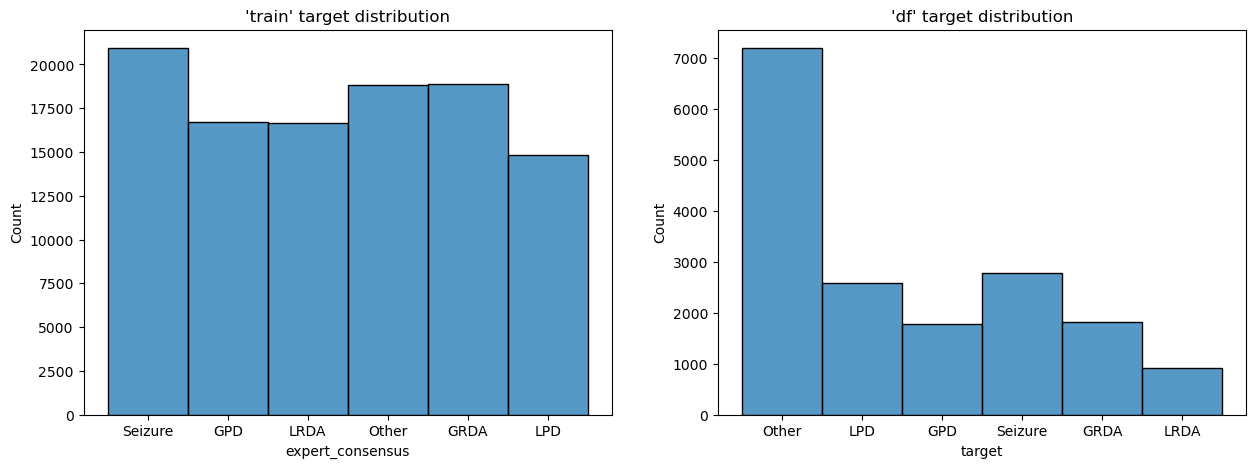

In [6]:
fig, ax = plt.subplots(1,2, figsize=(15,5))

sns.histplot(data=train.expert_consensus, ax=ax[0])
ax[0].set_title("'train' target distribution")

sns.histplot(data=df.target, ax=ax[1])
ax[1].set_title("'df' target distribution")

## Load data from files

In [7]:
def load_grouped(df, column='target',window=True):
    
    output = defaultdict(list)
    
    groups=df.groupby(column)
    
    for group_name, group_data in groups:
        
        print(f'Loading group {group_name}.')
        
        eegs, spects, labels = load_data(group_data.reset_index().drop('index', axis=1),window=window)
        
        output[group_name]+=[eegs, spects, labels]
        
    return output

## Load data from pickle

In [8]:
%%time
with open('data_dict.pkl', 'rb') as f:
    data = pickle.load(f)

CPU times: total: 5.27 s
Wall time: 8.85 s


In [9]:
data.keys()

dict_keys(['GPD', 'GRDA', 'LPD', 'LRDA', 'Other', 'Seizure'])

## Split data into train set and test set

Estou fazendo o split antes da remoção dos outliers. Isso significa que pode haver outliers no conjunto de teste. Como não sabemos se os dados de teste da competição possuem colunas absurdas, acredito que vale a pena tentar treinar o modelo dos dois jeitos: removendo os outliers antes e depois do split. Por ora seguirei com a segunda opção.

In [10]:
train_ratio = 0.80

In [11]:
train_data = {}
test_data = {}

for label, dados in data.items():
    
    eegs = dados[0]
    specs = dados[1]
    labels = dados[2]
    
    idx = [i for i in range(eegs.shape[0])]
    random.shuffle(idx)
    
    train_idx = idx[0:int(train_ratio*len(idx))]
    test_idx = idx[int(train_ratio*len(idx)):]
    
    train_data[label] = [eegs[train_idx], specs[train_idx], labels[train_idx]]
    test_data[label] = [eegs[test_idx], specs[test_idx], labels[test_idx]]

In [12]:
def plot_target_distribution(data, ax):
    
    labels = []
    freqs = []
    
    for label, dados in data.items():
        
        labels.append(label)
        freqs.append(dados[0].shape[0])
    
    ser = []
    
    for label, freq in zip(labels,freqs):
        ser+=[label]*freq
    
    ser = pd.Series(ser)
    
    sns.histplot(ser, ax=ax, kde=True)

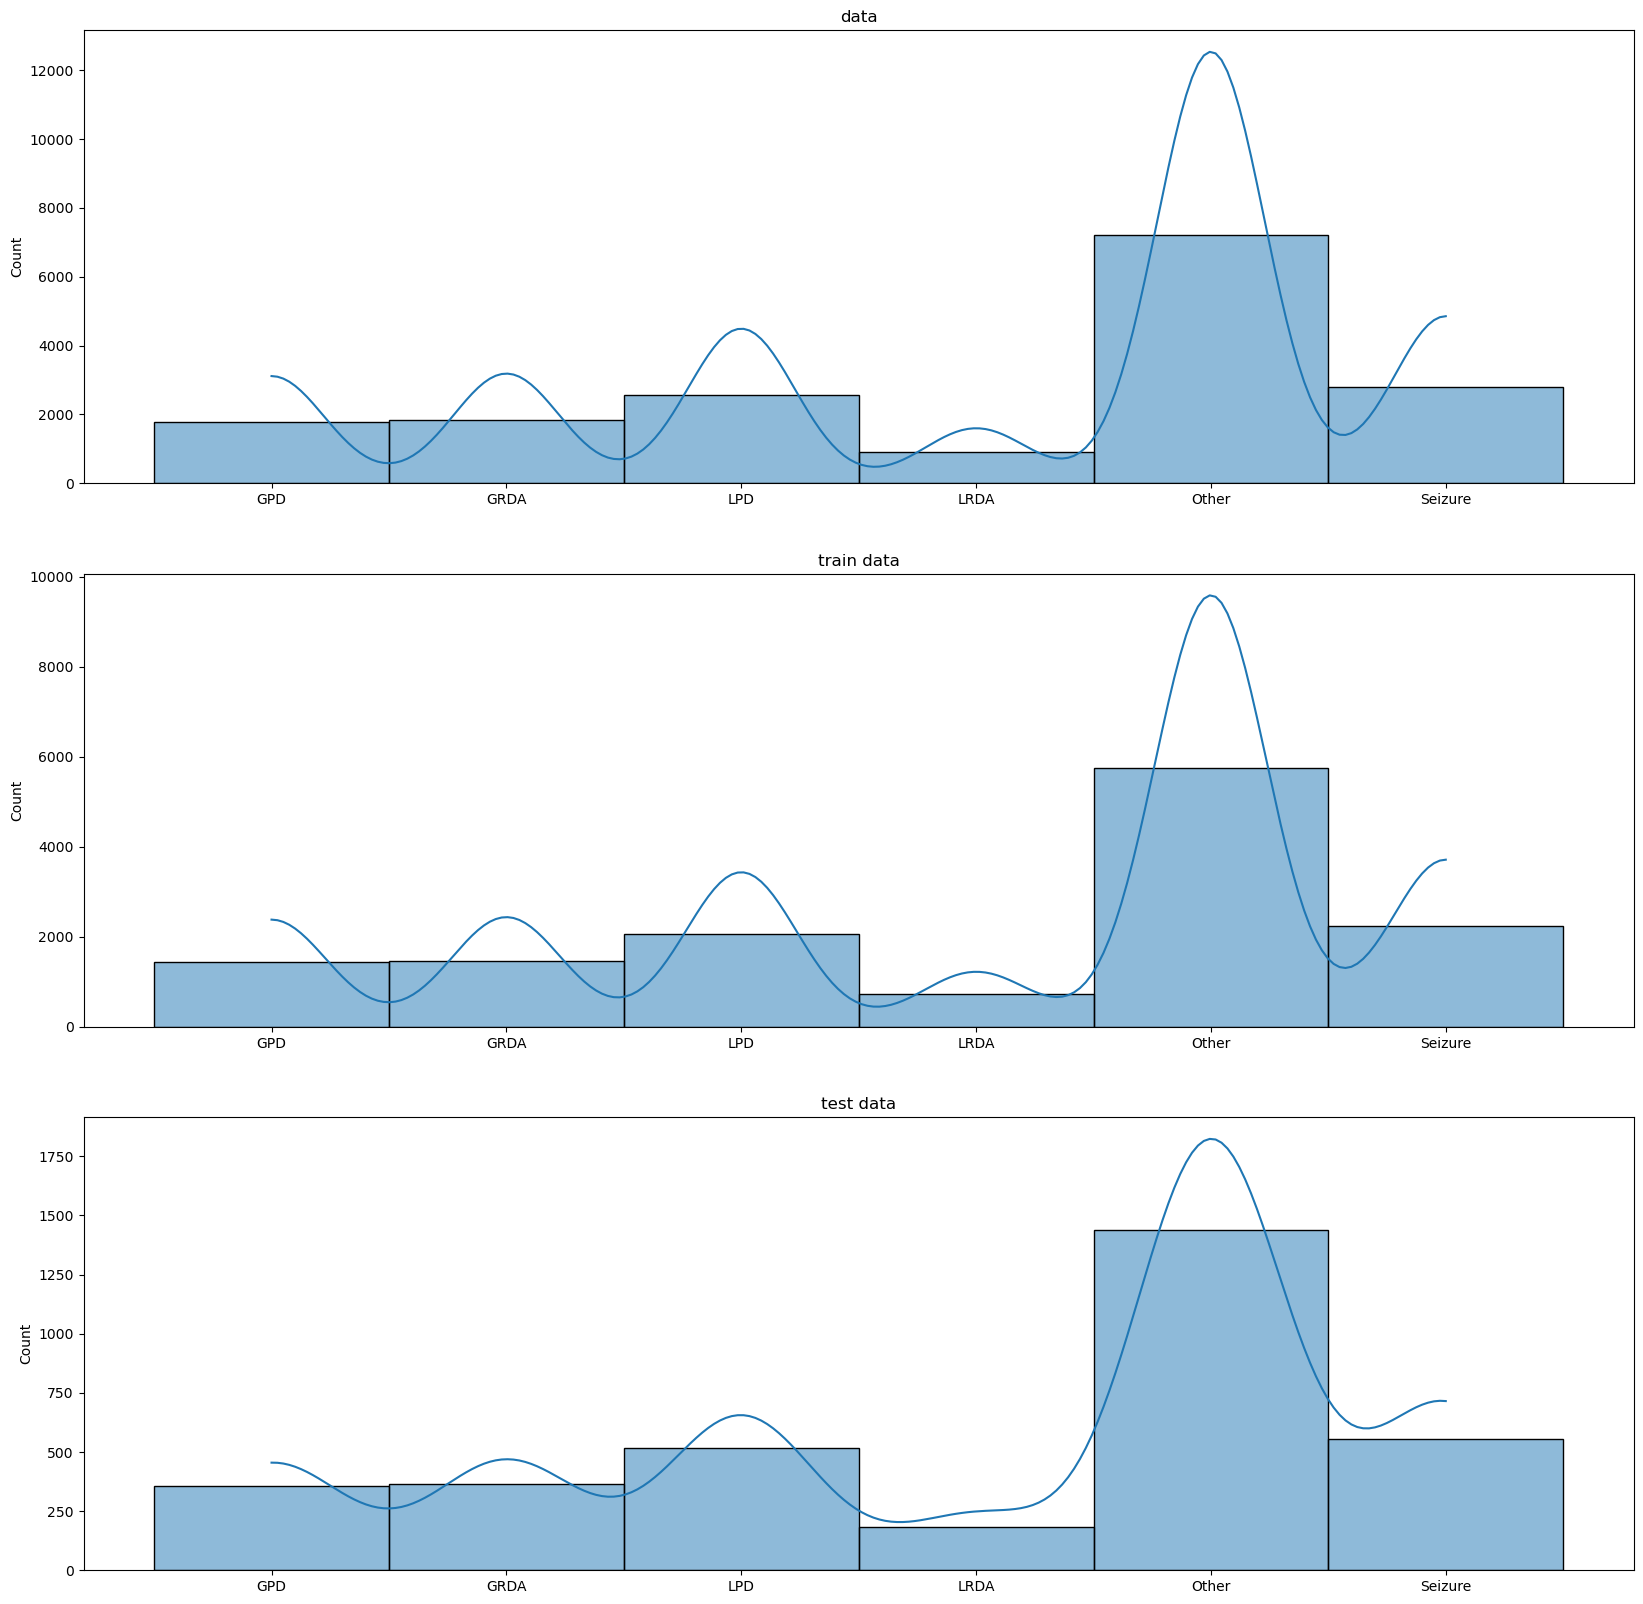

In [13]:
fig, ax = plt.subplots(3,figsize=(20,20))

titles=['data','train data', 'test data']

for i, dados in enumerate([data, train_data, test_data]):
    
    plot_target_distribution(dados,ax[i])
    ax[i].set_title(titles[i])

## Out, liers!

In [14]:
THRESHOLD = 10

In [15]:
liers=tell_liers(train_data['Seizure'][0])

In [16]:
bigliers=big_liers(liers, threshold=7)

Número de big liers: 304
Proporção de outliers: 0.13644524236983843


In [17]:
liers=tell_liers(train_data['Other'][0])

In [18]:
bigliers=big_liers(liers, threshold=7)

Número de big liers: 1104
Proporção de outliers: 0.19179986101459348


In [19]:
def remove_outliers(data,threshold=THRESHOLD):
    
    output={}
    
    for label, dados in data.items():
        
        print(label)
        
        eegs = dados[0]
        specs = dados[1]
        labels = dados[2]
        
        liers = tell_liers(eegs)
        idx_to_drop = big_liers(liers, threshold=threshold)
        
        output[label] = [np.delete(eegs, idx_to_drop, axis=0),np.delete(specs, idx_to_drop, axis=0),np.delete(labels, idx_to_drop, axis=0)]
        
        print('_________________________________________________________________________')
        
    return output

In [20]:
train_data = remove_outliers(train_data)

GPD
Número de big liers: 159
Proporção de outliers: 0.1112666200139958
_________________________________________________________________________
GRDA
Número de big liers: 139
Proporção de outliers: 0.09507523939808482
_________________________________________________________________________
LPD
Número de big liers: 229
Proporção de outliers: 0.1111111111111111
_________________________________________________________________________
LRDA
Número de big liers: 82
Proporção de outliers: 0.11202185792349727
_________________________________________________________________________
Other
Número de big liers: 882
Proporção de outliers: 0.1532314107018763
_________________________________________________________________________
Seizure
Número de big liers: 250
Proporção de outliers: 0.11220825852782765
_________________________________________________________________________


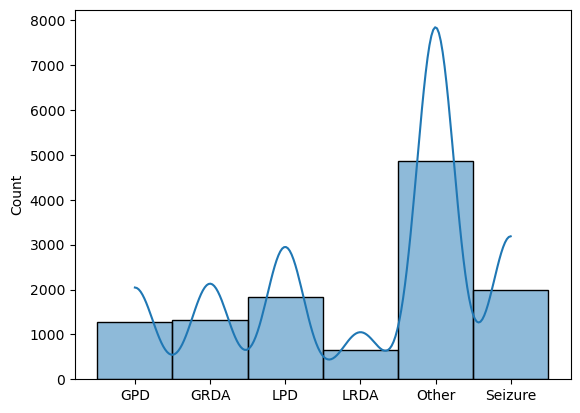

In [21]:
fig, ax = plt.subplots()

plot_target_distribution(train_data,ax=ax)

## Prune "Other" in train and test set

Amostras classificadas como "Other" são muito mais frequentes. Como não queremos que o modelo fique especialista em prever "Other" e esqueça de suas outras responsabilidades, irei remover amostras dessa classe até que os dados estejam mais balanceados.  

In [22]:
# calcular a média das quantidades de amostras de cada classe, exceto Other. 

lengths=[]

for label, dados in train_data.items():
    
    print(label)
    
    eegs=dados[0]
    specs=dados[1]
    labels=dados[2]
    
    length=eegs.shape[0]
    
    print(f'{length} samples')
    print('_________________________________________________________________________')
    
    if label != 'Other':
        lengths.append(length)
    
media_train = sum(lengths)/len(lengths)

print(f'Media (tirando "Other"): {media_train}')

GPD
1270 samples
_________________________________________________________________________
GRDA
1323 samples
_________________________________________________________________________
LPD
1832 samples
_________________________________________________________________________
LRDA
650 samples
_________________________________________________________________________
Other
4874 samples
_________________________________________________________________________
Seizure
1978 samples
_________________________________________________________________________
Media (tirando "Other"): 1410.6


In [23]:
# calcular a média das quantidades de amostras de cada classe, exceto Other. 

lengths=[]

for label, dados in test_data.items():
    
    print(label)
    
    eegs=dados[0]
    specs=dados[1]
    labels=dados[2]
    
    length=eegs.shape[0]
    
    print(f'{length} samples')
    print('_________________________________________________________________________')
    
    if label != 'Other':
        lengths.append(length)
    
media_test = sum(lengths)/len(lengths)

print(f'Media (tirando "Other"): {media_test}')

GPD
358 samples
_________________________________________________________________________
GRDA
366 samples
_________________________________________________________________________
LPD
516 samples
_________________________________________________________________________
LRDA
184 samples
_________________________________________________________________________
Other
1440 samples
_________________________________________________________________________
Seizure
557 samples
_________________________________________________________________________
Media (tirando "Other"): 396.2


In [24]:
train_data['Other']=[train_data['Other'][0][0:int(media_train)],train_data['Other'][1][0:int(media_train)],train_data['Other'][2][0:int(media_train)]]

In [25]:
test_data['Other']=[test_data['Other'][0][0:int(media_test)],test_data['Other'][1][0:int(media_test)],test_data['Other'][2][0:int(media_test)]]

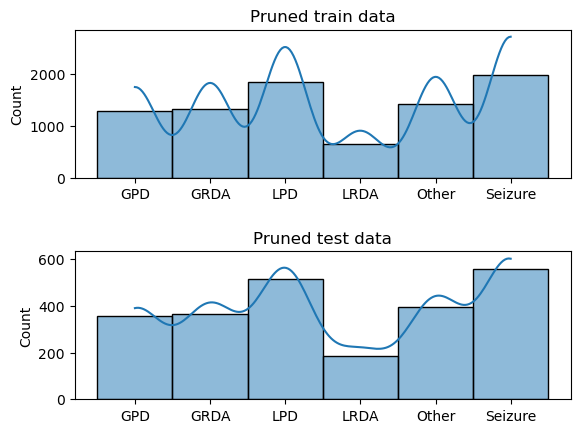

In [26]:
fig, ax = plt.subplots(2)

plot_target_distribution(train_data, ax=ax[0])
ax[0].set_title('Pruned train data')

plot_target_distribution(test_data, ax=ax[1])
ax[1].set_title('Pruned test data')

fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0, hspace=0.5)

## Data augmentation

Os dados ainda estão desbalanceados. Sugiro um aumento de amostras da classe LRDA, por exemplo. 
No entanto, vou passar esta etapa por enquanto. Depois testamos diferentes abordagens de data augmentation.

## Handle columns with std=0

Há colunas com std=0. Aceito sugestões de como tratar esses casos. Pensei em clusterizar as amostras por similaridade entre os vetores label normalizados e selecionar uma amostra representativa do cluster para "doar" cópias de suas colunas para outras amostras do mesmo cluster. Podemos inclusive aplicar uma softmax com temperatura elevada nas labels antes de clusterizar.

## Concatenate classes

In [27]:
train_eegs = np.concatenate([dados[0] for label, dados in train_data.items()])
train_specs = np.concatenate([dados[1] for label, dados in train_data.items()])
train_labels = np.concatenate([dados[2] for label, dados in train_data.items()])

In [28]:
test_eegs = np.concatenate([dados[0] for label, dados in test_data.items()])
test_specs = np.concatenate([dados[1] for label, dados in test_data.items()])
test_labels = np.concatenate([dados[2] for label, dados in test_data.items()])

In [29]:
train_eegs.shape[0]

8463

In [30]:
test_eegs.shape[0]

2377

## Denoise EEGs

Não implementei esta etapa, mas é algo que vale a pena considerarmos. 

Sugestão abaixo. Peguei desse link: https://www.kaggle.com/code/cdeotte/how-to-make-spectrogram-from-eeg?scriptVersionId=159854820

In [31]:
# DENOISE FUNCTION
# testar diferentes valores para "wavelet"

#import pywt

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise(x, wavelet='haar', level=1):    
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    ret=pywt.waverec(coeff, wavelet, mode='per')
    
    return ret

## Convert EEGs into Spectrograms

In [32]:
def to_df(data, columns=EEG_COL_NAMES):   
    df=pd.DataFrame(data=data, columns=columns)
    return df

In [33]:
df_sample = to_df(train_eegs[0])

In [34]:
df_sample

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-513.539978,-92.040001,-89.970001,-97.519997,-109.300003,-81.120003,-495.480011,-49.200001,-413.329987,-119.209999,-41.529999,-204.410004,-131.949997,-105.820000,-99.610001,-109.430000,-154.619995,-142.009995,-63.450001,15.440000
1,-492.320007,-64.410004,-60.820000,-67.639999,-84.389999,-49.029999,-494.109985,-25.100000,-380.959991,-82.730003,-6.500000,-179.389999,-87.639999,-66.370003,-63.840000,-53.029999,-111.029999,-108.970001,-31.930000,123.510002
2,-483.950012,-65.199997,-63.189999,-63.240002,-91.639999,-58.970001,-484.630005,-17.389999,-383.859985,-82.500000,-2.730000,-189.059998,-91.839996,-66.769997,-59.669998,-57.820000,-112.370003,-99.580002,-26.150000,56.930000
3,-533.940002,-109.260002,-100.519997,-96.589996,-140.320007,-107.760002,-507.220001,-51.990002,-421.329987,-118.669998,-36.299999,-218.259995,-129.639999,-105.000000,-95.889999,-103.059998,-150.740005,-138.960007,-62.590000,-3.220000
4,-536.919983,-98.220001,-86.680000,-80.650002,-114.910004,-83.050003,-494.040009,-35.919998,-409.910004,-104.760002,-22.049999,-191.570007,-115.989998,-91.779999,-85.209999,-87.919998,-143.199997,-136.630005,-52.669998,29.120001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,69.800003,49.240002,-0.910000,6.500000,6.620000,4.240000,29.389999,31.040001,59.830002,48.570000,44.279999,65.610001,35.779999,25.610001,17.230000,24.370001,57.830002,24.230000,17.290001,8.000000
1996,64.279999,42.860001,-6.890000,1.880000,-1.340000,0.190000,25.700001,26.230000,55.090000,42.250000,39.349998,61.009998,34.700001,21.549999,12.200000,33.540001,58.310001,20.360001,11.560000,11.020000
1997,57.869999,35.869999,-11.630000,-1.130000,-7.220000,-4.200000,21.620001,21.309999,49.360001,37.799999,35.810001,56.580002,29.129999,16.980000,8.730000,27.730000,55.500000,18.350000,8.750000,11.430000
1998,56.160000,36.020000,-9.090000,3.050000,-7.700000,-4.370000,20.070000,22.719999,50.380001,39.990002,37.970001,59.520000,31.680000,19.299999,10.890000,28.530001,54.369999,18.610001,11.740000,26.820000


In [35]:
NPERSEG = 400

In [36]:
def spec(data, nperseg=NPERSEG):
    return sp.signal.spectrogram(data,fs=200,nperseg=nperseg)

In [37]:
f, t , s = spec(df_sample['Fp1'])

In [38]:
t

array([1.  , 2.75, 4.5 , 6.25, 8.  ])

In [39]:
s.shape

(201, 5)

In [40]:
int(0.7*201)

140

In [41]:
f[1:141]

array([ 0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,  5.5,
        6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. , 10.5, 11. ,
       11.5, 12. , 12.5, 13. , 13.5, 14. , 14.5, 15. , 15.5, 16. , 16.5,
       17. , 17.5, 18. , 18.5, 19. , 19.5, 20. , 20.5, 21. , 21.5, 22. ,
       22.5, 23. , 23.5, 24. , 24.5, 25. , 25.5, 26. , 26.5, 27. , 27.5,
       28. , 28.5, 29. , 29.5, 30. , 30.5, 31. , 31.5, 32. , 32.5, 33. ,
       33.5, 34. , 34.5, 35. , 35.5, 36. , 36.5, 37. , 37.5, 38. , 38.5,
       39. , 39.5, 40. , 40.5, 41. , 41.5, 42. , 42.5, 43. , 43.5, 44. ,
       44.5, 45. , 45.5, 46. , 46.5, 47. , 47.5, 48. , 48.5, 49. , 49.5,
       50. , 50.5, 51. , 51.5, 52. , 52.5, 53. , 53.5, 54. , 54.5, 55. ,
       55.5, 56. , 56.5, 57. , 57.5, 58. , 58.5, 59. , 59.5, 60. , 60.5,
       61. , 61.5, 62. , 62.5, 63. , 63.5, 64. , 64.5, 65. , 65.5, 66. ,
       66.5, 67. , 67.5, 68. , 68.5, 69. , 69.5, 70. ])

In [42]:
CHAINS = {
    'LL' : [("Fp1","F7"),("F7","T3"),("T3","T5"),("T5","O1")],
    'RL' : [("Fp2","F8"),("F8","T4"),("T4","T6"),("T6","O2")],
    'LP' : [("Fp1","F3"),("F3","C3"),("C3","P3"),("P3","O1")],
    'RP' : [("Fp2","F4"),("F4","C4"),("C4","P4"),("P4","O2")]
}

In [43]:
def magic_spec(data):
    
    freqs, t, s = spec(data['Fp1'])
    n_rows=t.shape[0]
    f_lim = int(0.7*freqs.shape[0])+1
    output = []
    
    for region in CHAINS.keys():
        
        magic_spec = pd.DataFrame({region+str(f):[0]*n_rows for f in freqs[1:f_lim]})
        
        for pair in CHAINS[region]:
            
            f, t, s1 = spec(data[pair[0]])
            f, t, s2 = spec(data[pair[1]])
            
            magic_spec = magic_spec.add(pd.DataFrame(data=s1[1:f_lim].T-s2[1:f_lim].T, columns=[region+str(freq) for freq in f[1:f_lim]]))
            
        output.append(magic_spec/4)
        
    return pd.concat(output, axis=1)

In [44]:
magic_spec(df_sample)

,LL0.5,LL1.0,LL1.5,LL2.0,LL2.5,LL3.0,LL3.5,LL4.0,LL4.5,LL5.0,...,RP65.5,RP66.0,RP66.5,RP67.0,RP67.5,RP68.0,RP68.5,RP69.0,RP69.5,RP70.0
0,23676.682312,894.490211,284.063747,9.909897,-1.600739,52.500978,57.829386,24.323332,13.421355,4.817947,...,0.186385,0.347224,0.068839,0.042373,0.471107,0.674569,0.051859,0.075713,-0.046232,0.015814
1,2069.376007,369.307720,51.936975,16.422195,71.391180,13.392467,-1.137039,1.345787,3.759397,0.319363,...,-0.049577,0.078560,-0.033913,0.004545,0.032073,-0.036277,-0.020842,-0.098242,0.050275,0.010804
2,-42.753189,137.506033,179.407917,49.109855,12.556685,3.161936,10.620969,5.721990,4.584545,3.006102,...,0.034054,-0.025525,-0.008300,-0.051826,0.048324,0.017073,0.018937,0.001331,-0.004417,0.015462
3,38.496739,21.199146,70.440222,22.313950,1.276852,-4.655123,-3.633803,-2.642239,-4.330013,3.144743,...,0.035288,0.046315,-0.001064,-0.015238,0.003045,-0.025739,0.001368,-0.025937,-0.033852,0.032053
4,179.255439,146.823450,42.695520,27.398613,8.739530,0.891692,-4.799182,-3.744834,-0.502179,1.030463,...,-0.002544,-0.029306,0.045350,-0.025174,0.022377,0.126679,0.014211,-0.015234,0.011303,-0.001248


In [45]:
def eegs_to_spec(eegs):
    
    output=[]
    
    for eeg in eegs:
        
        spec = magic_spec(to_df(eeg)).values
        
        output.append(spec)
        
    return np.stack(output)

In [46]:
train_eegs.shape

(8463, 2000, 20)

In [47]:
%%time

tr_train_eegs = eegs_to_spec(train_eegs)

CPU times: total: 3min 9s
Wall time: 3min 57s


In [48]:
tr_train_eegs.shape

(8463, 5, 560)

In [49]:
test_eegs.shape

(2377, 2000, 20)

In [50]:
%%time

tr_test_eegs = eegs_to_spec(test_eegs)

CPU times: total: 1min
Wall time: 1min 4s


In [51]:
tr_test_eegs.shape

(2377, 5, 560)

In [52]:
train_specs.shape

(8463, 5, 400)

In [53]:
test_specs.shape

(2377, 5, 400)

## Checkpoint

Temos agora:

- tr_train_eegs
- train_specs
- train_labels
- tr_test_eegs
- test_specs
- test_labels

## Merge EEG Specs with Kaggle Specs

In [55]:
def assemble_data(tr_eegs, specs):
    
    if tr_eegs.shape[1]==specs.shape[1]: # verifica se os dois arrays têm o mesmo número de linhas
        
        output=[]
        
        for tr_eeg, spec in zip(tr_eegs, specs):
            
            output.append(np.concatenate((tr_eeg, spec), axis=1))
        
        return np.stack(output)
                          
    else:
        print('É preciso implentar o preenchimento de um dos arrays até que ambos tenham o mesmo shape.')      

In [56]:
%%time

X_train = assemble_data(tr_train_eegs, train_specs)

CPU times: total: 500 ms
Wall time: 687 ms


In [58]:
X_train.shape

(8463, 5, 960)

In [59]:
y_train = train_labels

In [60]:
y_train.shape

(8463, 6)

In [61]:
X_test = assemble_data(tr_test_eegs, test_specs)

In [62]:
y_test = test_labels

## Standardization (mean=0, std=1)

In [66]:
def normalize_data(tensor):
    
    normalized_tensor=[]
    
    for data in tensor:
        # Calculate mean and standard deviation for each column
        mean = np.mean(data, axis=0)
        std_dev = np.std(data, axis=0)
        if 0 in std_dev: std_dev+=0.0000001
        # Center the data by subtracting the mean
        centered_data = data - mean

        # Scale the data by dividing by the standard deviation
        normalized_data = centered_data / std_dev

        normalized_tensor.append(normalized_data)
        
    return np.stack(normalized_tensor)

In [73]:
X_train = normalize_data(X_train)

In [74]:
X_test = normalize_data(X_test)

In [75]:
tr_data={'X_train':X_train,'y_train':y_train,'X_test':X_test,'y_test':y_test}

In [76]:
# Specify the file path where you want to save the dictionary
file_path = 'tr_data.pkl'

# Open the file in binary write mode and save the dictionary using pickle
with open(file_path, 'wb') as f:
    pickle.dump(tr_data, f)